# Job Data Analysis

In [216]:
import gspread
from gspread_dataframe import set_with_dataframe
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/daikiminaki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#
gc = gspread.service_account(filename='datarebel-6576298f20fd.json')

def get_sheet_data(sheet, sheetname):
    # Open our new sheet and add some data.
    sh = gc.open(sheet)

    # Look at Item Sales Sheet
    sheet = sh.worksheet(sheetname)

    # Clean Item Sales DataFrame
    data = pd.DataFrame(sheet.get_all_values())

    try:
        if(data.shape[0] > 0):    
            data.columns = data.iloc[0] # Set Column
            data = data.iloc[1:]# Reset Table
            return data
    except:
        return data

def update_sheet(sheet, sheetname, dataset):
    # Get Current Data
    sheet_data = get_sheet_data(sheet, sheetname)

    # Combine with existing data
    dataset = pd.concat([sheet_data, dataset]).reset_index(drop=[1])

    # Look at Sheet
    sh = gc.open(sheet)
    worksheet = sh.worksheet(sheetname)
    set_with_dataframe(worksheet, dataset)

# Import Data

In [25]:
# Sheet and Worksheet Name
sheet = 'GlassDoorScraping - Data Analytics'
sheetname = 'Data'

job_df = get_sheet_data(sheet, sheetname)

In [26]:
job_df.head()

,company_name,job_title,job_link,location,salary_est,short_description,company_logo,company_banner,company_link,description,job_id,external_url,salary,company,ratings,reviews,why-work-here,benefits
1,AlohaCare,Data Analyst,https://www.glassdoor.com/partner/jobListing.h...,"Honolulu, HI",$50K - $64K (Employer est.),"Sciences, data analysis, accounting or related...",https://media.glassdoor.com/sql/266409/alohaca...,/static/img/banners/default-ei-banner.jpg,https://www.glassdoor.com/Overview/Working-at-...,"The Company:\nAlohaCare is a local, non-profit...",1008415699298,https://www.glassdoor.com/partner/jobListing.h...,"{'average_base_estimate': '$57,000 /yr (est.)'...","{'headquarter': 'Honolulu, HI', 'size': '201 t...","{'overall_rating': '2.9', 'recommend_company':...",{'pros': 'Pros\nNo Pros have been reported by ...,,
2,Sidekicks,Board Certified Behavior Analyst (BCBA),https://www.glassdoor.com/partner/jobListing.h...,Township of Hamilton,$95.00 Per Hour(Employer est.),Conduct re-assessments and develop plans that ...,,/static/img/banners/default-ei-banner.jpg,,Looking to grow with an organization and be a ...,,,"{'average_base_estimate': '$95.00 /hr (est.)',...",,,,,
3,Metropolitan Transportation Authority,"Cybersecurity Analyst Levels 1-7, Data Scientist",https://www.glassdoor.com/partner/jobListing.h...,Manhattan,,Provides guidance and technical coaching to le...,https://media.glassdoor.com/sql/366592/mta-met...,/static/img/banners/default-ei-banner.jpg,https://www.glassdoor.com/Overview/Working-at-...,Job Information\n\n\nJob Title: Cybersecurity ...,1008359249694,https://www.glassdoor.com/partner/jobListing.h...,,"{'headquarter': 'New York, NY', 'size': 'Unkno...","{'overall_rating': '3.6', 'recommend_company':...","{'pros': 'Pros\n""Good benefits and able to mov...",,
4,Uline,Associate eCommerce Data Analyst,https://www.glassdoor.com/partner/jobListing.h...,"Pleasant Prairie, WI",$61K - $89K (Glassdoor est.),"Bachelor's degree in Marketing, Information Sy...",https://media.glassdoor.com/sql/26828/uline-sq...,https://media.glassdoor.com/banner/bh/26828/ul...,https://www.glassdoor.com/Overview/Working-at-...,Associate eCommerce Data Analyst\nCorporate He...,1008314527886,https://www.glassdoor.com/partner/jobListing.h...,"{'average_base_estimate': '$73,868 /yr (est.)'...","{'headquarter': 'Pleasant Prairie, WI', 'size'...","{'overall_rating': '3.4', 'recommend_company':...","{'pros': 'Pros\n""Good benefits Good team Growi...","{'Culture': '', 'Warehouse': '', 'Sales': '', ...","{'rating': '4.4', 'rating_count': '', 'employe..."
5,Cleveland-Cliffs,Procurement Analyst - Plant Services,https://www.glassdoor.com/partner/jobListing.h...,"West Chester, OH",$62K - $87K (Glassdoor est.),To evaluate alternative sourcing strategies Mi...,https://media.glassdoor.com/sql/157/cleveland-...,https://media.glassdoor.com/banner/bh/157/clev...,https://www.glassdoor.com/Overview/Working-at-...,Cleveland-Cliffs has an immediate opening for ...,1008429169476,https://www.glassdoor.com/partner/jobListing.h...,"{'average_base_estimate': '$73,394 /yr (est.)'...","{'headquarter': 'Cleveland, OH', 'size': '1000...","{'overall_rating': '3.7', 'recommend_company':...","{'pros': 'Pros\n""good pay and benefits from da...",,


# Clean Data

In [130]:
import json

## General
def json_string_to_json(value):
    try:
        if type(value) == str:
            jsonVal = json.loads(value.replace('"','').replace("'",'"'))
            return jsonVal
        else:
            return value
    except:
        return None

def get_json_value(x, value):
    try:
        return x[value]
    except:
        return None
    
def expand_json(column_name):
    # Get Keys for Json
    variable_keys = list(job_cleaning[job_cleaning[column_name].notnull()][column_name].iloc[0].keys())
    
    # Break Json variables into Columns
    for key in variable_keys:
        job_cleaning[key] = job_cleaning[column_name].apply(lambda x: get_json_value(x, key))
        
        
## Salary
def clean_base_salary_figure(x):
    if x:
        return float(x.split(' ')[0].replace('$','').replace(',',''))
    else:
        return None
    
def clean_base_salary_type(x):
    if x:
        return x.split(' ')[1]
    else:
        return None

In [132]:
# 
job_cleaning = job_df.copy()

# Columns in 
json_columns = ['salary','company','ratings','reviews','why-work-here','benefits']

# Json-Strings to Json
for column in json_columns:
    # Json-Columns to Json
    job_cleaning[column] = job_cleaning[column].apply(lambda x: json_string_to_json(x))
    
    # Json Variables to Individual Columns
    expand_json(column)
    
# Remove Misc Columns
misc_columns=['Culture','Warehouse','Sales','Technology','Service/Support']
job_cleaning = job_cleaning[[x for x in job_cleaning.columns if x not in misc_columns]]


# Clean Salary
job_cleaning['salary_rate'] = job_cleaning['average_base_estimate'].apply(lambda x: clean_base_salary_figure(x))
job_cleaning['salary_type'] = job_cleaning['average_base_estimate'].apply(lambda x: clean_base_salary_type(x))

print('Salary Raw:\n{}\n'.format(job_cleaning['salary'][1]))
print('Rate: {}'.format(job_cleaning['salary_rate'][1]))
print('Type: {}'.format(job_cleaning['salary_type'][1]))

Salary Raw:
{'average_base_estimate': '$57,000 /yr (est.)', 'base_range_min': '$50K ', 'base_range_max': '$64K', 'area_summary_url': ''}

Rate: 57000.0
Type: /yr


# Explore Data

In [66]:
# 
job_details_columns = ['company_name','job_title']
job_cleaning.head(2)

,company_name,job_title,job_link,location,salary_est,short_description,company_logo,company_banner,company_link,description,...,culture_and_values,senior_management,pros,cons,rating,rating_count,employee_summary,top_benefit_review_1,top_benefit_review_2,top_benefit_review_3
1,AlohaCare,Data Analyst,https://www.glassdoor.com/partner/jobListing.h...,"Honolulu, HI",$50K - $64K (Employer est.),"Sciences, data analysis, accounting or related...",https://media.glassdoor.com/sql/266409/alohaca...,/static/img/banners/default-ei-banner.jpg,https://www.glassdoor.com/Overview/Working-at-...,"The Company:\nAlohaCare is a local, non-profit...",...,3.3,2.8,Pros\nNo Pros have been reported by the Glassd...,"Cons\nZero training, zero support, passive agg...",None,None,None,None,None,None
2,Sidekicks,Board Certified Behavior Analyst (BCBA),https://www.glassdoor.com/partner/jobListing.h...,Township of Hamilton,$95.00 Per Hour(Employer est.),Conduct re-assessments and develop plans that ...,,/static/img/banners/default-ei-banner.jpg,,Looking to grow with an organization and be a ...,...,None,None,None,None,None,None,None,None,None,None


In [346]:
### Function for EDA (Exploratory Data Analysis)

# Plot Distribution
def plot_distribution(data,title='',column_x='', column_y=''):
    print('\nAverage {}: {}'.format(title, data.mean()))
    print('Count: {}'.format(data.count()))
    _ = plt.figure(figsize=(10,6))
    _ = plt.hist(data,bins=20)
    _ = plt.axvline(data.mean(), color='red')
    _ = plt.title(title,size=13)
    _ = plt.xlabel(column_x)
    _ = plt.ylabel(column_y)
    plt.show()
    
# Plot Bar Chart
def plot_barplot(data,x,y,title='',figsize=(8,10)):
    _ = plt.figure(figsize=figsize)
    _ = sns.barplot(x=x, y=y, data=data.head(20))
    _ = plt.title(title, size=15)

# Plot Pie Chart
def plot_pieplot(values,labels,title='',figsize=(8,10)):
    _ = plt.figure(figsize=figsize)
    _ = plt.pie(values, labels=labels, autopct='%.0f%%')
    _ = plt.title(title, size=15)

## 1. Basic Info

## 1a. Title

In [247]:
def generate_N_grams(text,ngram=1):
    text = text.lower().replace(' - ',' ').translate(str.maketrans('', '', string.punctuation))
    words=[word for word in text.split(" ") if word not in set(stopwords.words('english'))]  
    temp=zip(*[words[i:] for i in range(0,ngram)])
    ans=[' '.join(ngram) for ngram in temp]
    return ans

In [258]:
# Get n_grams from Job Titles
job_list = list(job_cleaning['job_title'].apply(lambda x: generate_N_grams(x,2)))
n_gram_2_jobs = [y for x in job_list for y in x]

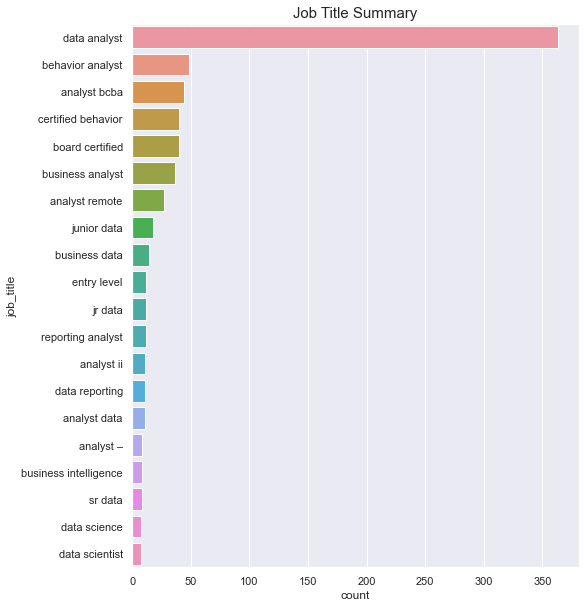

In [345]:
# Get Value Counts
job_title_summary = pd.DataFrame(pd.Series(n_gram_2_jobs).value_counts())
job_title_summary = job_title_summary.reset_index()
job_title_summary.columns = ['job_title','count']

# Plot Titles
plot_barplot(job_title_summary,'count','job_title','Job Title Summary',figsize=(8,10))

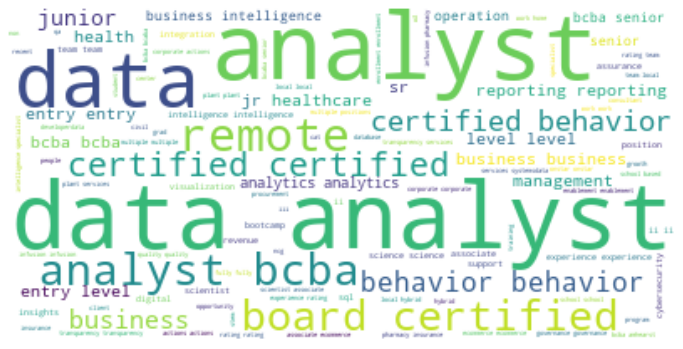

In [295]:
# Create and generate a word cloud image:
wordcloud = WordCloud(background_color='white').generate(' '.join(n_gram_2_jobs))

# Display the generated image:
_ = plt.figure(figsize=(12,10))
_ = plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")
_ = plt.show()

## 2b. Work Location

In [296]:
# Work Locations
work_location_df = pd.DataFrame(job_cleaning['location'].value_counts()).reset_index()
work_location_df.columns = ['location','count']

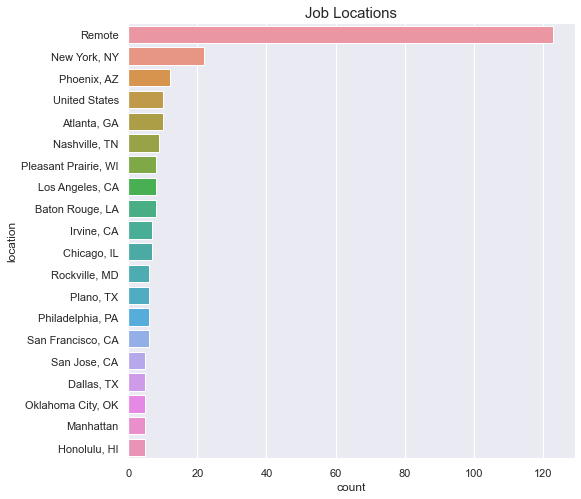

In [343]:
# Plot Titles
plot_barplot(work_location_df,'count','location','Job Locations',figsize=(8,8))

## 2. Salary

In [136]:
# Get Salary Cols
salary_columns = ['salary_rate','salary_type','salary','average_base_estimate','base_range_min','base_range_max','area_summary_url']

# Get Salary Data
salary_df = job_cleaning[job_details_columns + salary_columns]
salary_df.head(3)

,company_name,job_title,salary_rate,salary_type,salary,average_base_estimate,base_range_min,base_range_max,area_summary_url
1,AlohaCare,Data Analyst,57000.0,/yr,"{'average_base_estimate': '$57,000 /yr (est.)'...","$57,000 /yr (est.)",$50K,$64K,
2,Sidekicks,Board Certified Behavior Analyst (BCBA),95.0,/hr,"{'average_base_estimate': '$95.00 /hr (est.)',...",$95.00 /hr (est.),$95.00 /hr,$95.00,
3,Metropolitan Transportation Authority,"Cybersecurity Analyst Levels 1-7, Data Scientist",NaN,None,None,None,None,None,None


In [140]:
# Salary Types 
salary_df.salary_type.value_counts()

/yr    331
/hr     82
/mo      3
Name: salary_type, dtype: int64


Average Salary Rate - Yearly Jobs: 75536.14803625377
Count: 331


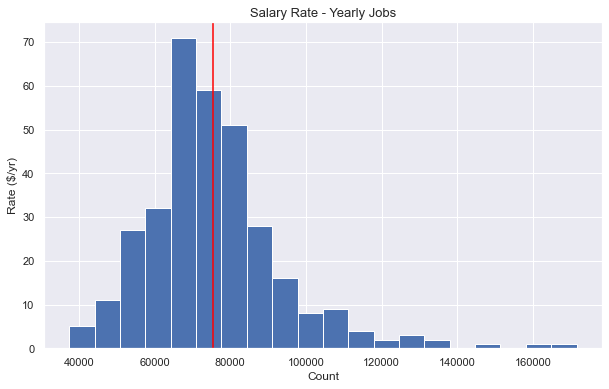


Average Salary Rate - Hourly Jobs: 50.44609756097561
Count: 82


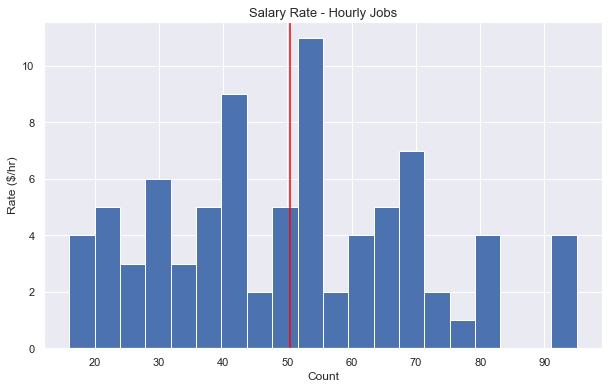


Average Salary Rate - Monthly Jobs: 6085.333333333333
Count: 3


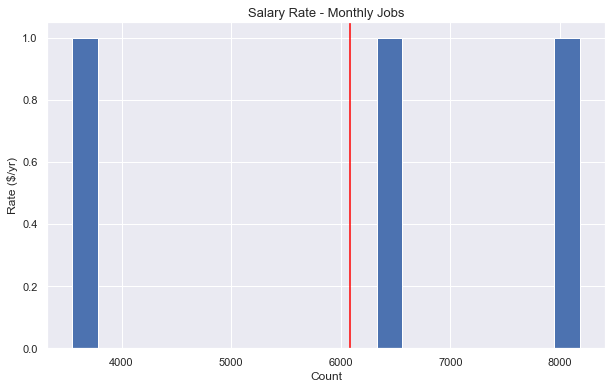

In [194]:
# Separate by Type
yearly_jobs = salary_df[salary_df['salary_type'] == '/yr']
hourly_jobs = salary_df[salary_df['salary_type'] == '/hr']
monthly_jobs = salary_df[salary_df['salary_type'] == '/mo']

# Plot Salary Rates for Yearly jobs
plot_distribution(yearly_jobs['salary_rate'],'Salary Rate - Yearly Jobs','Count','Rate ($/yr)')

# Plot Salary Rates for Hourly jobs
plot_distribution(hourly_jobs['salary_rate'],'Salary Rate - Hourly Jobs','Count','Rate ($/hr)')

# Plot Salary Rates for Monthly jobs
plot_distribution(monthly_jobs['salary_rate'],'Salary Rate - Monthly Jobs','Count','Rate ($/yr)')

# 2. Company

In [199]:
# Get Company Cols
company_cols = ['headquarter','size','year_founded','type','industry','sector','revenue','website','company']

# Get Company Data
company_df = job_cleaning[job_details_columns + company_cols]
company_df.head(3)

,company_name,job_title,headquarter,size,year_founded,type,industry,sector,revenue,website,company
1,AlohaCare,Data Analyst,"Honolulu, HI",201 to 500 Employees,1994,Nonprofit Organization,Health Care Services & Hospitals,Healthcare,Unknown / Non-Applicable,http://www.alohacare.org/,"{'headquarter': 'Honolulu, HI', 'size': '201 t..."
2,Sidekicks,Board Certified Behavior Analyst (BCBA),None,None,None,None,None,None,None,None,None
3,Metropolitan Transportation Authority,"Cybersecurity Analyst Levels 1-7, Data Scientist","New York, NY",Unknown,,Government,State & Regional Agencies,Government & Public Administration,Unknown / Non-Applicable,http://www.mta.info/,"{'headquarter': 'New York, NY', 'size': 'Unkno..."


## 2a. Company Sizes

In [305]:
#
sizes = ['1 to 50 Employees','51 to 200 Employees','201 to 500 Employees','501 to 1000 Employees','1001 to 5000 Employees','5001 to 10000 Employees','10000+ Employees','Unknown']
sizevalues = pd.DataFrame(job_cleaning['size'].value_counts()).T

#
company_sizes = sizevalues[sizes].T.reset_index()
company_sizes.columns = ['company_size','count']

In [366]:
company_sizes

,company_size,count
0,1 to 50 Employees,79
1,51 to 200 Employees,62
2,201 to 500 Employees,41
3,501 to 1000 Employees,46
4,1001 to 5000 Employees,84
5,5001 to 10000 Employees,31
6,10000+ Employees,99
7,Unknown,40


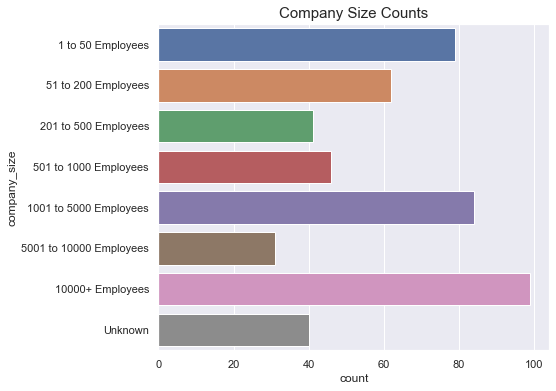

In [348]:
# Plot Sizes
plot_barplot(company_sizes,'count','company_size','Company Size Counts',(7,6))

Not so Interesting... pretty evenly distributed


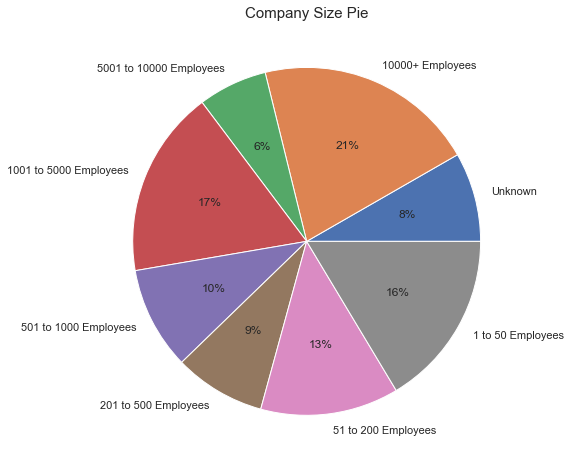

In [372]:
# Prep Variables
values = list(company_sizes['count'])
labels = list(company_sizes['company_size'])
values.reverse()
labels.reverse()

#
plot_pieplot(values, labels,'Company Size Pie', (12,8))
print('Not so Interesting... pretty evenly distributed')

## 2b. Company Size Vs Salary

In [ ]:
# 
sizeIndex = dict(zip(sizes, range(len(sizes))))

def add_index(x):
    if x != None:
        return sizeIndex[x]
    else:
        return None

In [460]:
# 
size_vs_salary = job_cleaning[job_cleaning['size'] != 'Unknown'][['size','salary_type','salary_rate']].copy()
size_vs_salary['order'] = size_vs_salary['size'].apply(lambda x: add_index(x))

# Types
size_yr = size_vs_salary[size_vs_salary['salary_type'] == '/yr']
size_hr = size_vs_salary[size_vs_salary['salary_type'] == '/hr']

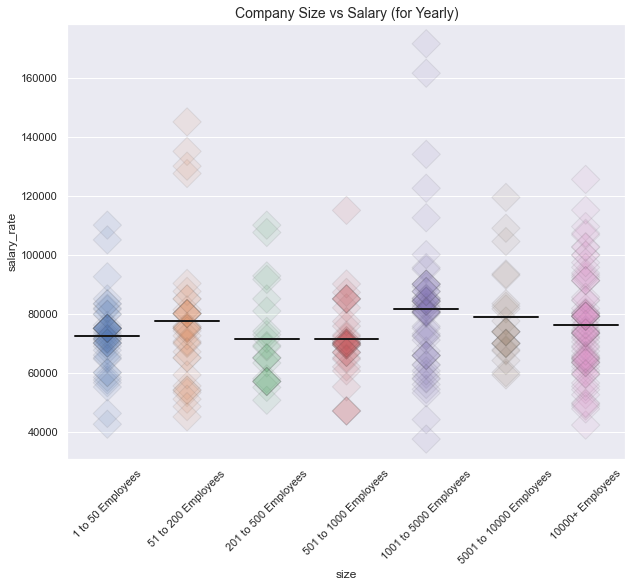

In [464]:
# plot the Strip line
_ = plt.figure(figsize=(10,8))
_ = plt.xticks(rotation=45)
_ = plt.title('Company Size vs Salary (for Yearly)', size=14)
_ = plt.ylabel('Yearly Salary Rate ($USD)')
_ = sns.stripplot(
        data=size_yr.sort_values('order').dropna(), x="size", y="salary_rate",
        jitter=False, s=20, marker="D", linewidth=1, alpha=.1)
# plot the mean line
_ = sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="size",
            y="salary_rate",
            data=size_yr.sort_values('order').dropna(),
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=_)

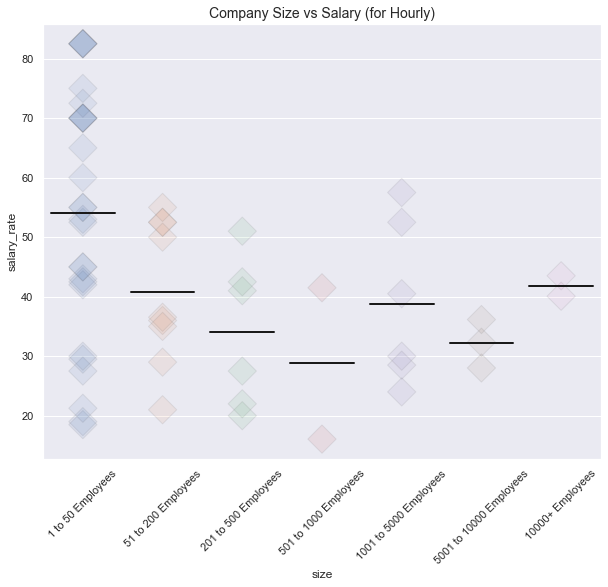

In [465]:
# plot the Strip line
_ = plt.figure(figsize=(10,8))
_ = plt.xticks(rotation=45)
_ = plt.title('Company Size vs Salary (for Hourly)', size=14)
_ = plt.ylabel('Hourly Salary Rate ($USD)')
_ = sns.stripplot(
        data=size_hr.sort_values('order').dropna(), x="size", y="salary_rate",
        jitter=False, s=20, marker="D", linewidth=1, alpha=.1)
# plot the mean line
_ = sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="size",
            y="salary_rate",
            data=size_hr.sort_values('order').dropna(),
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=_)

## 2c. Company Years

In [477]:
# 
company_years = company_df[(company_df['year_founded'].notnull()) & (company_df['year_founded'] != '')]

#
years = pd.DataFrame(company_years['year_founded'].value_counts()).reset_index()
years.columns = ['year_founded','count']

### Year Founded

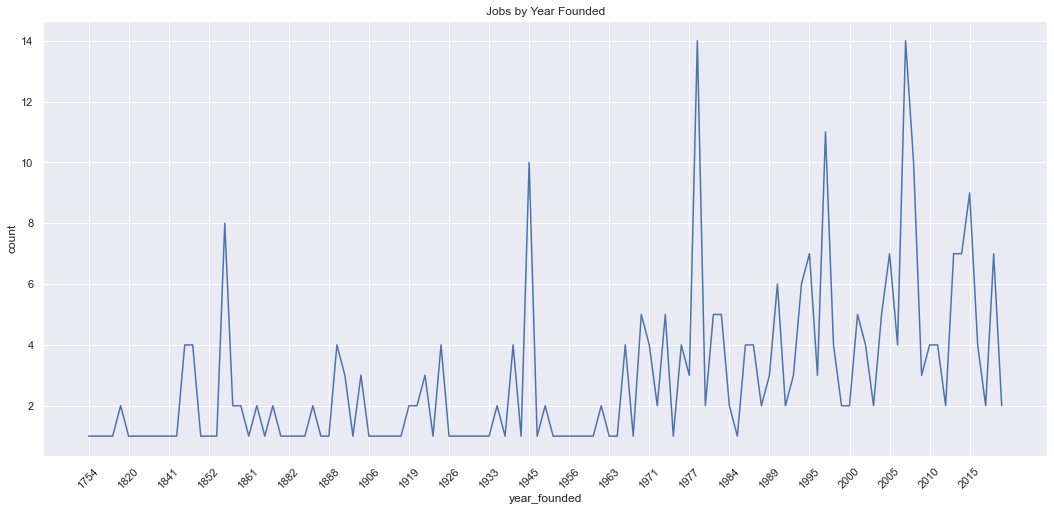

In [544]:
# Plot Year Founded
_ = plt.figure(figsize=(18,8))
_ = sns.lineplot(data=years.sort_values('year_founded'), x='year_founded',y='count')
_ = plt.xticks(list(years.sort_values('year_founded')['year_founded'])[::5], rotation=45)
_ = plt.title('Jobs by Year Founded')

In [546]:
# 
year_vs_salary = job_cleaning[['year_founded','salary_rate']].dropna()
year_vs_salary = year_vs_salary[year_vs_salary['year_founded'] != '']

# Column Values
year_vs_salary['salary_rate'] = year_vs_salary['salary_rate'].astype(int)
year_vs_salary['year_founded'] = year_vs_salary['year_founded'].astype(int)

### Year Founded vs Salary
No Correlation

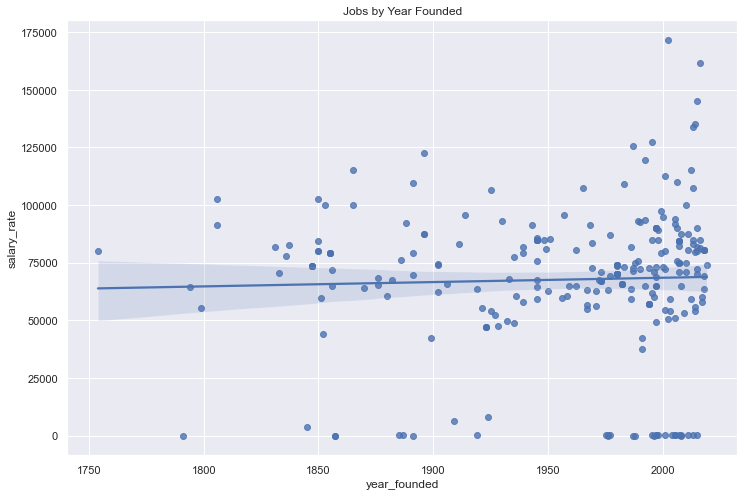

In [560]:
# Plot Year Founded
_ = plt.figure(figsize=(12,8))
_ = sns.regplot(data=year_vs_salary, x='year_founded',y='salary_rate')
_ = plt.title('Year Founded vs Salary')

## 2d. Organization Type

In [563]:
company_df.head(2)

,company_name,job_title,headquarter,size,year_founded,type,industry,sector,revenue,website,company
1,AlohaCare,Data Analyst,"Honolulu, HI",201 to 500 Employees,1994,Nonprofit Organization,Health Care Services & Hospitals,Healthcare,Unknown / Non-Applicable,http://www.alohacare.org/,"{'headquarter': 'Honolulu, HI', 'size': '201 t..."
2,Sidekicks,Board Certified Behavior Analyst (BCBA),None,None,None,None,None,None,None,None,None


In [565]:
company_df.type.value_counts()

Company - Private                 247
Company - Public                  126
Nonprofit Organization             39
College / University               19
Government                         16
Unknown                            10
Hospital                            9
Subsidiary or Business Segment      7
Private Practice / Firm             4
Contract                            3
Franchise                           1
School / School District            1
Name: type, dtype: int64

## Organization Type vs Salary

In [578]:
# 
type_vs_salary = job_cleaning[['type','salary_rate','salary_type']].copy().dropna()
type_vs_salary = type_vs_salary[type_vs_salary['type'] != '']

# Column Values
type_vs_salary['salary_rate'] = type_vs_salary['salary_rate'].astype(int)

# Types
type_vs_salary_yr = type_vs_salary[type_vs_salary['salary_type'] == '/yr']
type_vs_salary_hr = type_vs_salary[type_vs_salary['salary_type'] == '/hr']

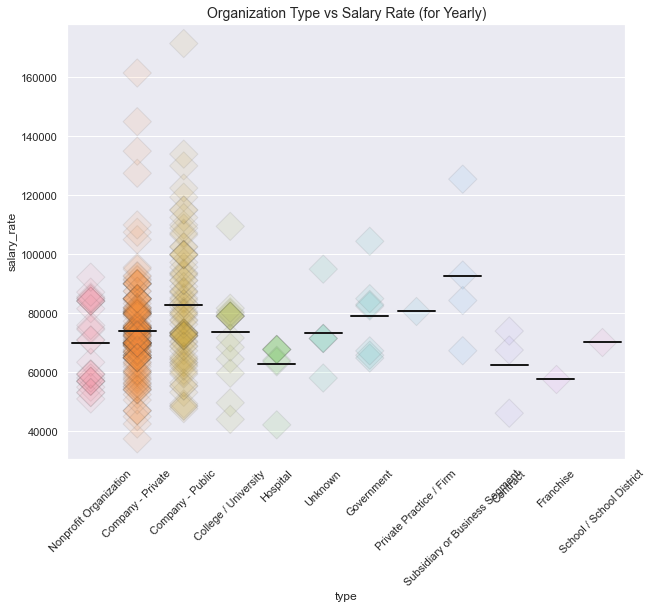

In [583]:
# plot the Strip line
_ = plt.figure(figsize=(10,8))
_ = plt.xticks(rotation=45)
_ = plt.title('Organization Type vs Salary Rate (for Yearly)', size=14)
_ = plt.ylabel('Yearly Salary Rate ($USD)')
_ = sns.stripplot(
        data=type_vs_salary_yr, x="type", y="salary_rate",
        jitter=False, s=20, marker="D", linewidth=1, alpha=.1)
# plot the mean line
_ = sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="type",
            y="salary_rate",
            data=type_vs_salary_yr,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=_)

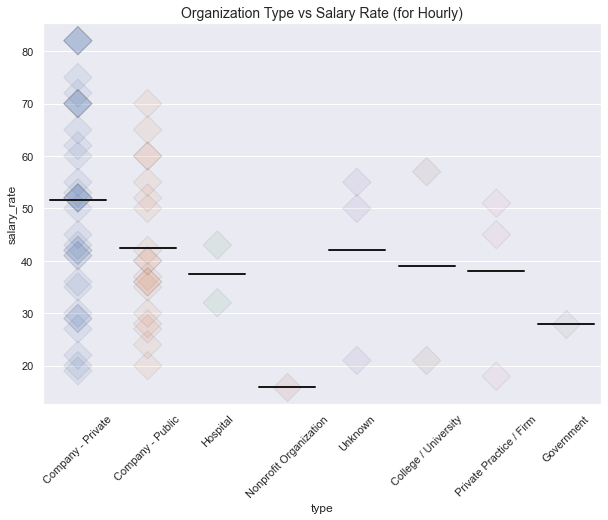

In [582]:
# plot the Strip line
_ = plt.figure(figsize=(10,7))
_ = plt.xticks(rotation=45)
_ = plt.title('Organization Type vs Salary Rate (for Hourly)', size=14)
_ = plt.ylabel('Yearly Salary Rate ($USD)')
_ = sns.stripplot(
        data=type_vs_salary_hr, x="type", y="salary_rate",
        jitter=False, s=20, marker="D", linewidth=1, alpha=.1)
# plot the mean line
_ = sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="type",
            y="salary_rate",
            data=type_vs_salary_hr,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=_)

## 2e. Industry & Sector

In [564]:
company_df.head(2)

,company_name,job_title,headquarter,size,year_founded,type,industry,sector,revenue,website,company
1,AlohaCare,Data Analyst,"Honolulu, HI",201 to 500 Employees,1994,Nonprofit Organization,Health Care Services & Hospitals,Healthcare,Unknown / Non-Applicable,http://www.alohacare.org/,"{'headquarter': 'Honolulu, HI', 'size': '201 t..."
2,Sidekicks,Board Certified Behavior Analyst (BCBA),None,None,None,None,None,None,None,None,None


## Industry + Sector

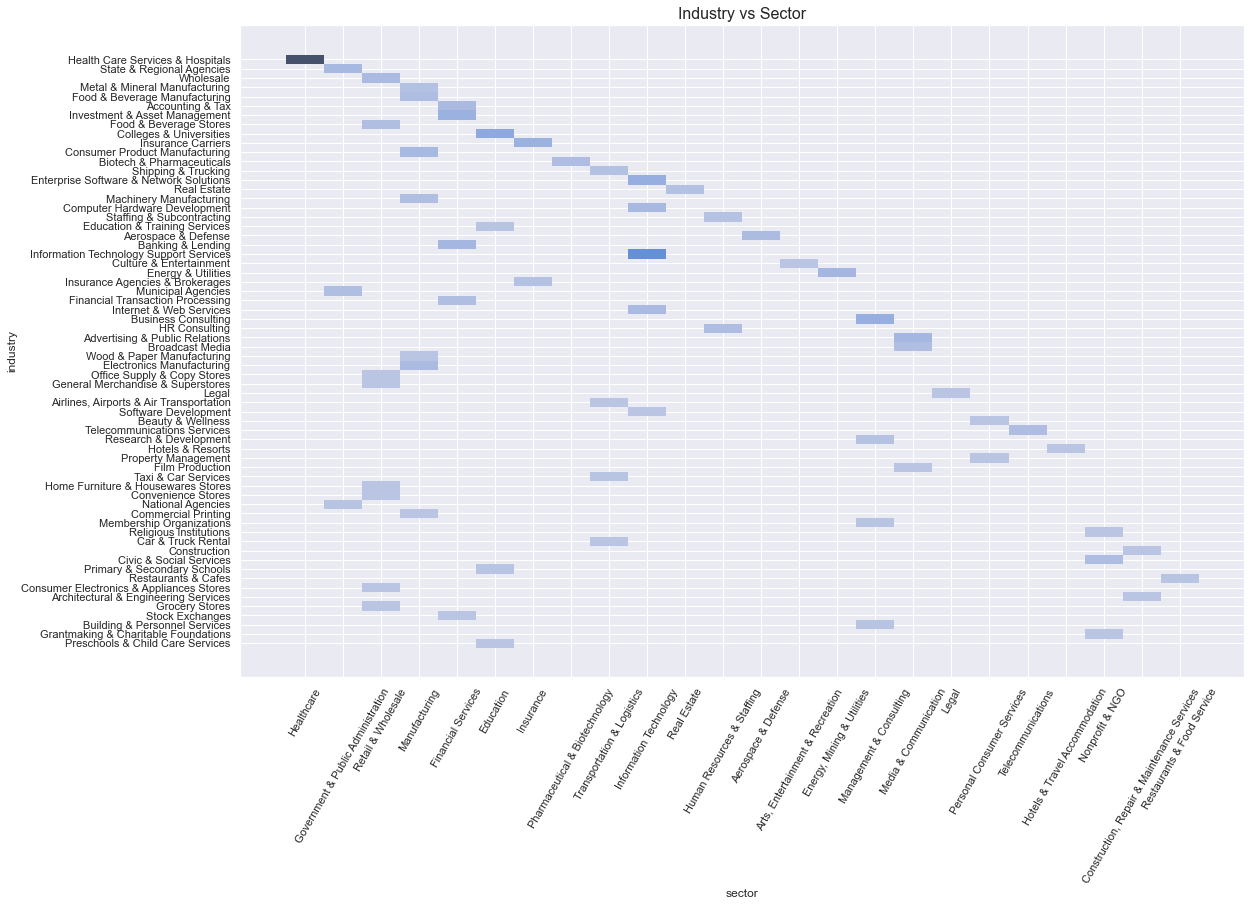

In [621]:
# Clean Industry vs Sector
industry_and_sector = company_df[(company_df['industry'] != '') & (company_df['sector'] != '')][['sector','industry']].dropna()

# Plot Industry
_ = plt.figure(figsize=(18,12))
_ = sns.histplot(data=industry_and_sector, x='sector',y='industry')
_ = plt.title('Industry vs Sector', size=16)
_ = plt.xticks(rotation=60)

### Industry and Organization Type

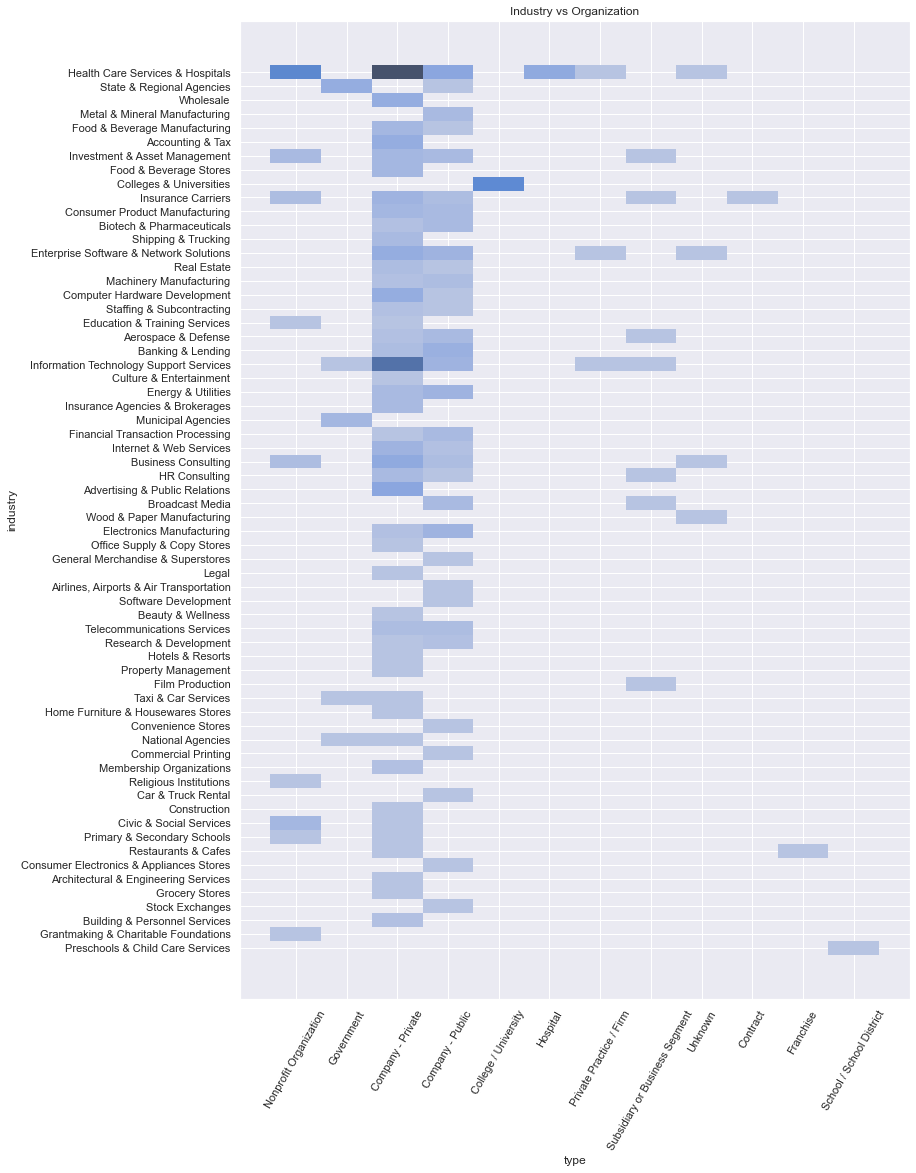

In [622]:
# Clean Industry vs Org
industry_vs_organization = company_df[(company_df['industry'] != '') & (company_df['type'] != '')][['type','industry']].dropna()

# Plot Industry
_ = plt.figure(figsize=(12,18))
_ = sns.histplot(data=industry_vs_organization, x='type',y='industry')
_ = plt.title('Industry vs Organization', size=16)
_ = plt.xticks(rotation=60)

### Sector vs Organization Type

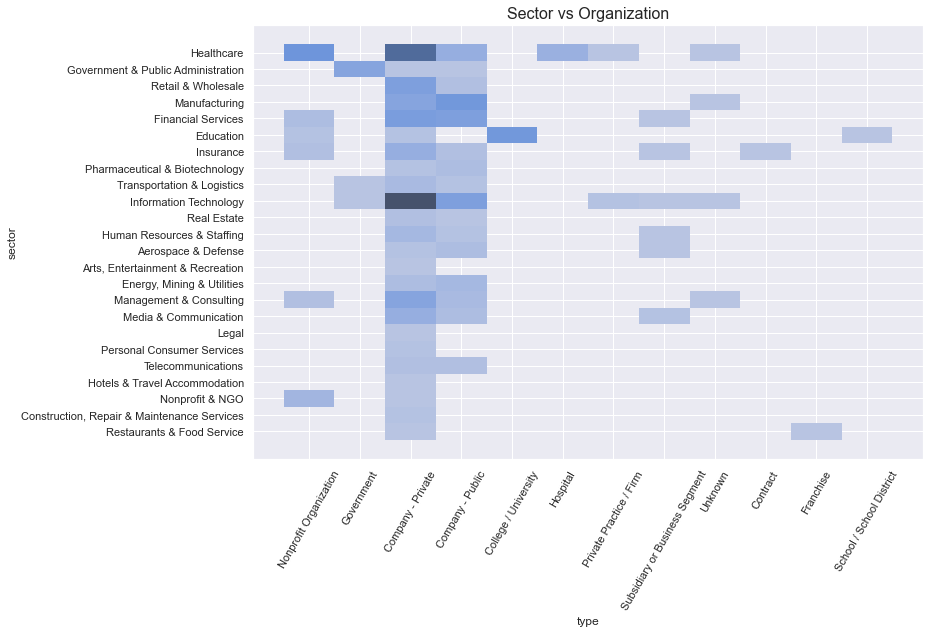

In [628]:
# Clean Industry vs Org
sector_vs_organization = company_df[(company_df['sector'] != '') & (company_df['type'] != '')][['type','sector']].dropna()

# Plot Industry
_ = plt.figure(figsize=(12,8))
_ = sns.histplot(data=sector_vs_organization, x='type',y='sector')
_ = plt.title('Sector vs Organization', size=16)
_ = plt.xticks(rotation=60)

## 

In [578]:
# 
type_vs_salary = job_cleaning[['type','salary_rate','salary_type']].copy().dropna()
type_vs_salary = type_vs_salary[type_vs_salary['type'] != '']

# Column Values
type_vs_salary['salary_rate'] = type_vs_salary['salary_rate'].astype(int)

# Types
type_vs_salary_yr = type_vs_salary[type_vs_salary['salary_type'] == '/yr']
type_vs_salary_hr = type_vs_salary[type_vs_salary['salary_type'] == '/hr']

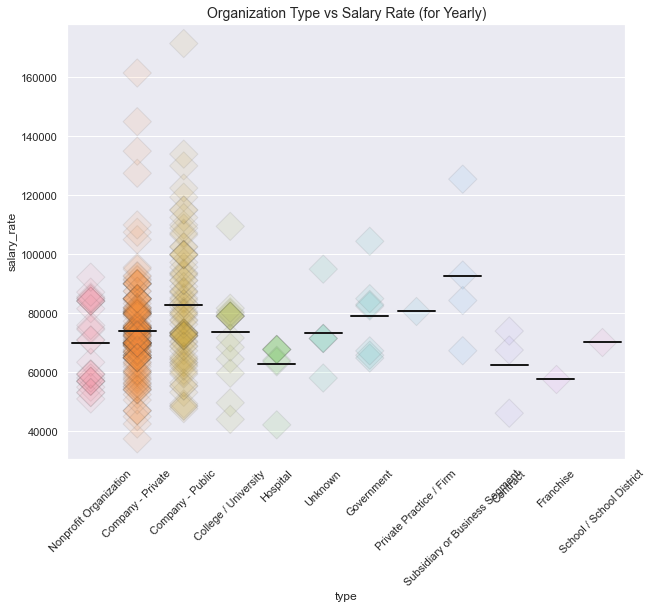

In [583]:
# plot the Strip line
_ = plt.figure(figsize=(10,8))
_ = plt.xticks(rotation=45)
_ = plt.title('Organization Type vs Salary Rate (for Yearly)', size=14)
_ = plt.ylabel('Yearly Salary Rate ($USD)')
_ = sns.stripplot(
        data=type_vs_salary_yr, x="type", y="salary_rate",
        jitter=False, s=20, marker="D", linewidth=1, alpha=.1)
# plot the mean line
_ = sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="type",
            y="salary_rate",
            data=type_vs_salary_yr,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=_)

# Rating
### Unfinished

In [ ]:
# Get Ratings Cols
ratings_cols = ['overall_rating', 'recommend_company', 'ceo_rating', 'ceo_name', 'ceo_rating_count', 'career_opportunities', 'comp_and_benefit', 'culture_and_values', 'senior_management','ratings']

# Get Ratings Data
ratings_df = job_cleaning[job_details_columns + ratings_cols]
ratings_df.head(3)

# Reviews
### Unfinished

# Why Work Here
### Unfinished

# Benefits
### Unfinished

# Job Details
### Unfinished

In [68]:
job_cleaning.iloc[0]

0
company_name                                                     AlohaCare
job_title                                                     Data Analyst
job_link                 https://www.glassdoor.com/partner/jobListing.h...
location                                                      Honolulu, HI
salary_est                                     $50K - $64K (Employer est.)
short_description        Sciences, data analysis, accounting or related...
company_logo             https://media.glassdoor.com/sql/266409/alohaca...
company_banner                   /static/img/banners/default-ei-banner.jpg
company_link             https://www.glassdoor.com/Overview/Working-at-...
description              The Company:\nAlohaCare is a local, non-profit...
job_id                                                       1008415699298
external_url             https://www.glassdoor.com/partner/jobListing.h...
salary                   {'average_base_estimate': '$57,000 /yr (est.)'...
company                